In [0]:
import torch
import torch.nn as nn
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader
from skimage import io,transform
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
import torchvision
import matplotlib.pyplot as plt

Used to eliminate from the list of all images the ones that cant be read. Checked and these images from the original link also don't open in the browser, looks like they are just generally corrupted

In [0]:
import os
df = pd.read_csv('/content/drive/My Drive/Resonance/AllImageData.csv')
df = pd.DataFrame(df['Image Name'])
l = []
root_dir = '/content/drive/My Drive/Resonance/Images'
print(len(df))
new_df = df.copy()
for i in range(len(list(df.iloc[:,0]))):
  spec_name = 'Num.'+str(df.iloc[i,0])+'.jpg'
  img_name = os.path.join(root_dir,spec_name)
  try: 
    io.imread(img_name)
  except:
    new_df = new_df.drop(i)
print(len(new_df))

1534


In [0]:
#new_df.to_csv('/content/drive/My Drive/Resonance/AllImageData.csv',index=False)

Importing from nets.py each of the net classes, which is required when I loaded each of them back in to make tag predictions for each of the images

In [0]:
import torch.nn as nn
import sys
sys.path.insert(0,'/content/drive/My Drive/Resonance/Notebooks')
from nets import ColorNet,GenreNet,BodyNet,ChiefNet,TypeNet,UseNet

Loading all images preprocessed images into lists

In [0]:
import os
from PIL import Image
df = pd.read_csv('/content/drive/My Drive/Resonance/AllImageData.csv')

root_dir = '/content/drive/My Drive/Resonance/Images'
images64 = []
transform = transforms.Compose([transforms.Resize((64,64)),
        transforms.ToTensor(),transforms.Normalize(mean=[.5,.5,.5],
                             std=[.5,.5,.5])])
for idx in range(len(df)):
  spec_name = 'Num.'+str(df.iloc[idx,0])+'.jpg'
  img_name = os.path.join(root_dir,spec_name)
  image = Image.open(img_name).convert('RGB')
  image64 = transform(image)
  images64.append(image64)

Convert list of images into a tensor of appropriate dimensions

In [0]:
images64 = torch.stack(images64)

Load pretrained neural nets and add them to one of two dictionaries based on whether the category is single label or multi label

In [0]:
multi_nets = {} #dict with keys=name of category and vals=net for that category
multi_nets['Genre'] = torch.load('/content/drive/My Drive/Resonance/GenreNet.pt')
multi_nets['Use'] = torch.load('/content/drive/My Drive/Resonance/UseNet.pt')
multi_nets['Type'] = torch.load('/content/drive/My Drive/Resonance/TypeNet.pt')

single_nets = {} #same as multi nets but for single class classifiers
single_nets['Primary Color'] = torch.load('/content/drive/My Drive/Resonance/ColorNet.pt')
single_nets['Body'] = torch.load('/content/drive/My Drive/Resonance/BodyNet.pt')
single_nets['Chief'] = torch.load('/content/drive/My Drive/Resonance/ChiefNet.pt')

Instantiate dictionaries that hold the probs for each image for each category

In [0]:
multi_probs = {}  #dict with keys= name of category and vals=predicted probabilities for each option of that category
single_probs = {}

Get the probabilities for each image in each of the multi label classes and add them to dictionary

In [7]:
import os
from PIL import Image

multi_64 = ['Genre','Use','Type']
for net_name in multi_64:
  print(net_name)
  net = multi_nets[net_name]
  outputs = net(images64)
  prob = torch.sigmoid(outputs.data).numpy()
  multi_probs[net_name] = prob

Genre
Use
Type


Make the predictions into a data frame and append each categories dataframe to a list, then in next block concat dataframes

In [0]:
dfs = []
for i in multi_probs.keys():
  one = pd.DataFrame(multi_probs[i])
  one.index = df['Image Name']
  one = pd.concat([one],keys=[i],names=['Category Type'],axis=1)
  dfs.append(one)

In [0]:
multi_df = pd.concat(dfs,axis=1)
multi_df.to_csv('/content/drive/My Drive/Resonance/Multi.csv')
pd.read_csv('/content/drive/My Drive/Resonance/Multi.csv',header=[0,1],index_col=0)

Same thing above but for single label categories

In [10]:
for net_name in single_nets.keys():
  print(net_name)
  net = single_nets[net_name]
  outputs = net(images64)
  prob = nn.functional.softmax(outputs).detach().numpy()
  single_probs[net_name] = prob

Primary Color


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """


Body
Chief


In [0]:
single_dfs = []
for i in single_probs.keys():
  one = pd.DataFrame(single_probs[i])
  one.index = df['Image Name']
  one = pd.concat([one],keys=[i],names=['Category Type'],axis=1)
  single_dfs.append(one)
single_df = pd.concat(single_dfs,axis=1)

In [0]:
single_df.to_csv('/content/drive/My Drive/Resonance/Single.csv')

Combine single and multi label dataframes

In [0]:
image_tag_probs = pd.concat([single_df,multi_df],axis=1)
image_tag_probs.to_csv('/content/drive/My Drive/Resonance/TagProbs.csv')
image_tag_probs = pd.read_csv('/content/drive/My Drive/Resonance/TagProbs.csv',header=[0,1],index_col=0)

In [0]:
cats = list(image_tag_probs.groupby(axis=1,level=0).max().columns)

In [0]:
final = pd.read_csv('/content/drive/My Drive/Resonance/OriginalImageData.csv',index_col=0)
final = final.set_index('Image Name')['ID']
final = pd.concat([final],keys=['Original Data'],names=['Category Type'],axis=1)
test = pd.concat([final,image_tag_probs],axis=1)

Groupby the original item IDs. Then apply functions to convert probabilities to binary labels

In [0]:
single_cats = list(single_probs.keys())
multi_cats = list(multi_probs.keys())

In [0]:
def binarize(x):
  if x>.6:
    return 1
  else:
    return 0
for i in range(len(one)):
  m = one.iloc[i].max()
  single = one.iloc

In [0]:
def softmax_binary(one):
  m = np.zeros_like(one.values)
  m[np.arange(len(one)), one.values.argmax(1)] = 1
  df1 = pd.DataFrame(m, columns = one.columns,index=one.index).astype(int)
  return df1

In [0]:
t2 = test.groupby('ID').max()
bins = []
for cat in multi_cats:
  one = t2[[(x,y) for x,y in list(t2.columns) if cat in x]]
  one = one.applymap(binarize)
  bins.append(one)

In [0]:
for cat in single_cats:
  one = t2[[(x,y) for x,y in list(t2.columns) if cat in x]]
  bins.append(softmax_binary(one))

In [0]:
'''binary = pd.concat(bins,axis=1).to_csv('/content/drive/My Drive/Resonance/BinaryPredictions.csv')
current_columns = list(binary.columns)
current_columns = [literal_eval(x) for x in current_columns]
cols_binary = list(genre)+list(use)+list(typ)+list(colors)+list(body)+list(chief)
for i in range(len(current_columns)):
  x,y = current_columns[i]
  y = cols_binary[i]
  current_columns[i] = (x,y)
binary.columns = pd.MultiIndex.from_tuples(current_columns)
binary.to_csv('/content/drive/My Drive/Resonance/BinaryPredictions.csv')'''

In [0]:
binary = pd.read_csv('/content/drive/My Drive/Resonance/BinaryPredictions.csv',header=[0,1],index_col=0)

In [0]:
embed = pd.read_csv('/content/drive/My Drive/Resonance/TagProbs.csv',header=[0,1],index_col=0)

Codes used to convert integer categories to string categories

In [0]:
import pandas as pd
color_codes = pd.read_csv('/content/drive/My Drive/Resonance/PrimaryColorCodes.csv',index_col=0)
colors = color_codes.sort_values('0').index

body_codes = pd.read_csv('/content/drive/My Drive/Resonance/BodyCodeChart.csv',index_col=0)
body = body_codes.sort_values('0').index

chief_codes = pd.read_csv('/content/drive/My Drive/Resonance/ChiefCodeChart.csv',index_col=0)
chief = chief_codes.sort_values('0').index

genre_codes = pd.read_csv('/content/drive/My Drive/Resonance/GenreData.csv').transpose().iloc[1:].reset_index().iloc[:,:1]
genre = genre_codes['index']

use_codes = pd.read_csv('/content/drive/My Drive/Resonance/UseData.csv').transpose().iloc[1:].reset_index().iloc[:,:1]
use = use_codes['index']

type_codes = pd.read_csv('/content/drive/My Drive/Resonance/TypeData.csv').transpose().iloc[1:].reset_index().iloc[:,:1]
typ = type_codes['index']

cols = list(colors)+list(body)+list(chief)+list(genre)+list(use)+list(typ)

In [0]:
#embed = embed[['Genre','Body','Use']]

# VISUALIZATIONS

Embeddings vectors into 2d so they can be plotting onto scatter plot

In [0]:
from sklearn.manifold import TSNE
import numpy as np

X = np.array(embed.values)
X_embedded = TSNE(n_components=2).fit_transform(X)

In [0]:
scatter_x = [x[0] for x in X_embedded]
scatter_y = [x[1] for x in X_embedded]
#scatter_z = [x[2] for x in X_embedded]

In [341]:
import plotly.graph_objects as go
import plotly
fig = go.Figure(go.Scatter(x=scatter_x,y=scatter_y,mode='markers',
                             marker=dict(color=np.linspace(0, 20, len(scatter_x)),size=5,colorscale='Viridis'),text=list(embed.index)))
fig.update_xaxes(title_text='Feature 1')
fig.update_yaxes(title_text='Feature 2')
fig.update_layout(title='2D Image Vector Embeddings')
plotly.offline.plot(fig, filename='/content/drive/My Drive/Resonance/Presentation/Embed.html')

'/content/drive/My Drive/Resonance/Presentation/Embed.html'

2D Histogram

In [0]:
color = binary['Primary Color'].copy()
color['Code'] = ['nan' for x in range(len(color))]
color['Color'] = ['nan' for x in range(len(color))]
for i in range(len(color)):
  row = color.iloc[i]
  color['Color'].iat[i] = list(row.loc[row==1].index)[0]
color['Codes'] = color['Color'].astype('category').cat.codes

In [0]:
chief = binary['Chief'].copy()
chief['Chief'] = ['nan' for x in range(len(color))]
for i in range(len(chief)):
  row = chief.iloc[i]
  chief['Chief'].iat[i] = list(row.loc[row==1].index)[0]
chief['Codes'] = chief['Chief'].astype('category').cat.codes

In [342]:
fig1 = go.Figure(go.Histogram2d(x=color['Color'], y=chief['Chief'],
        colorscale=[[0, 'rgb(12,51,131)'], [0.25, 'rgb(10,136,186)'], [0.5, 'rgb(242,211,56)'], [0.75, 'rgb(242,143,56)'], [1, 'rgb(217,30,30)']]
    ))
fig1.update_xaxes(title_text='Color')
fig1.update_yaxes(title_text='Chief')
fig1.update_layout(title='Color and Chief 2D Histogram')
plotly.offline.plot(fig1, filename='/content/drive/My Drive/Resonance/Presentation/Hist.html')

'/content/drive/My Drive/Resonance/Presentation/Hist.html'

In [336]:
import plotly.graph_objects as go

fig = go.Figure(go.Histogram2dContour(
        x = color['Color'],
        y = chief['Chief'],
        colorscale = 'Blues'
))

fig.show()

# SIMILAR IMAGES FUNCTION

In [0]:
from sklearn.metrics.pairwise import cosine_distances
distances = cosine_distances(X)

In [0]:
import os
from PIL import Image

def similar_images(num):
  num = embed.index.get_loc(num) #convert the input which is image name to the iloc of the image
  sim = pd.DataFrame(distances[num],index=embed.index).sort_values(0).head(4)
  ims = list(sim.index)
  root_dir = '/content/drive/My Drive/Resonance/Images'
  rows=2
  columns=2
  fig=plt.figure(figsize=(8, 8))
  for i in range(0, columns*rows):
    img = ims[i]
    spec_name = 'Num.'+str(img)+'.jpg'
    img_name = os.path.join(root_dir,spec_name)
    image = Image.open(img_name)
    if i==0:
      title = 'Original Item'
    else:
      title = 'Similar Item No. '+str(i)
    fig.add_subplot(rows, columns, i+1,title=title,xticks=[],yticks=[])
    plt.imshow(image)
  fname = 'Similar Images to '+str(num)+'.png'
  plt.savefig('/content/drive/My Drive/Resonance/Presentation/'+fname)
  plt.show()

In [0]:
good_examples = [1427,1513,802,69,70,75,80,85,105,93]

93,1427,69,

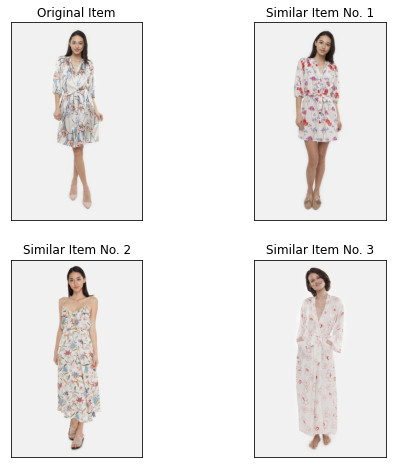

In [20]:
similar_images(1427)

# Converting binary tags to the form origninally given to me

In [0]:
final = pd.read_csv('/content/drive/My Drive/Resonance/OriginalImageData.csv',index_col=0)
final = final.groupby('ID').first()

In [0]:
tags = ['TAGS: Color','TAGS: Material','TAGS: Body']
def step(idx,name):
  one = have_tags[name].iat[idx]
  l = one.split(',')
  l2 = [x.strip() for x in l]
  l3 = [x.split(' ') for x in l2]
  one = pd.DataFrame(l3)
  one = one.groupby(0)[1].apply(list)
  one = pd.DataFrame(one)
  #print([str(have_tags['Image Name'].iat[idx])])
  #one = one.columns=[str(have_tags['Image Name'].iat[idx])]
  return one
tag_dfs = []
for i in tags:
  final[i] = final[i].fillna(0)
  need_tags = final.loc[(final[i]==('None'))|(final[i]==0)]
  have_tags = final.loc[~final.index.isin(list(need_tags.index))]
  have_tags = have_tags.reset_index()

  for x in range(len(have_tags)):
    name = have_tags['ID'].iat[x]
    if x==0:
      all_df = step(x,i)
    else:
      all_df[name] = step(x,i).iloc[:,0]
  t = all_df.transpose()
  tag_dfs.append(t)

In [0]:
body_df = tag_dfs[2]
color_df = tag_dfs[0]
mat_df = tag_dfs[1]

In [0]:
concat_list = [final]
for i in tag_dfs:
  concat_list.append(i)

In [0]:
final_split = pd.concat(concat_list,axis=1)

In [0]:
ctest = pd.get_dummies(t['Body'])

In [0]:
true = np.array(ctest.values)

In [0]:
from sklearn.metrics import accuracy_score
preds = binary['Body'].loc[ctest.index]

In [178]:
accuracy_score(true,np.array(preds.values))

0.964963503649635

In [0]:
from ast import literal_eval

emptyd = {'Genre':None,'Use':None,'Type':None,'Primary Color':None,'Body':None,'Chief':None}
d = {}
#for i in list(binary.index):
  #d[i] = emptyd
cats = ['Use','Type','Genre','Primary Color','Chief','Body']
lod = []
for i in list(binary.index):
  this_dict = {}
  ind = binary.loc[i].loc[binary.loc[i]==1].index
  df = pd.DataFrame(list(ind)).set_index(0)
  for cat in cats:
    if cat in list(df.index):
      one = df.loc[cat][1]
      if type(one)==str:
        fin = [one]
      if type(one)==pd.core.series.Series:
        fin = list(one)
      this_dict[cat] = fin
  lod.append(this_dict)

In [0]:
final_split = final_split.fillna(0)
final_split = final_split.rename(columns={'Primary':'Primary Color'})
for row in list(final_split.index):
  line = final_split.loc[row]
  for i in list(line.index):
    if i in cats:
      if line[i]==0:
        try:
          final_split.at[row,i] = lod[row-1][i]
        except:
          final_split.at[row,i] = 'None'
      elif line[i]=='None':
        final_split.at[row,i] = lod[row-1][i]

In [0]:
final_split['PRED TAGS: Body'] = ['none' for x in range(len(final_split))]
for row in list(final_split.index):
  line = final_split.loc[row]
  joined = []
  for i in list(line.index):
    if line['brand_code']=='JR':
      joined.append(['none'])
      break
    if i in list(body_df.columns):
      if type(line[i])==list:
        for x in line[i]:
          joined.append([i,x])
      elif type(line[i])==str:
        joined.append([i,line[i]])
  joined = [' '.join(x) for x in joined]
  joined = ','.join(joined)
  final_split['PRED TAGS: Body'].at[row] = joined

In [0]:
final_split['PRED TAGS: Color'] = ['a' for x in range(len(final_split))]
for row in list(final_split.index):
  line = final_split.loc[row]
  joined = []
  for i in list(line.index):
    l = list(color_df.columns)
    l.append('Primary Color')
    if i in list(l):
      if type(line[i])==list:
        for x in line[i]:
          joined.append([i,x])
      elif type(line[i])==str:
        joined.append([i,line[i]])
  joined = [' '.join(x) for x in joined]
  joined = ','.join(joined)
  final_split['PRED TAGS: Color'].at[row] = joined

In [0]:
final_split['PRED TAGS: Material'] = ['a' for x in range(len(final_split))]
for row in list(final_split.index):
  line = final_split.loc[row]
  joined = []
  for i in list(line.index):
    if i in list(mat_df.columns):
      if type(line[i])==list:
        for x in line[i]:
          joined.append([i,x])
      elif type(line[i])==str:
        joined.append([i,line[i]])
  joined = [' '.join(x) for x in joined]
  joined = ','.join(joined)
  final_split['PRED TAGS: Material'].at[row] = joined

In [0]:
final_split[[x for x in list(final_split.columns) if 'PRED' in x]]

In [0]:
final['TAGS: Color'] = final_split['PRED TAGS: Color']
final['TAGS: Material'] = final_split['PRED TAGS: Material']
final['TAGS: Body'] = final_split['PRED TAGS: Body']

In [0]:
final.to_csv('/content/drive/My Drive/Resonance/FINALTagOutput.csv')